# MNIST

This task utilizes a simple neural network containing single n-task context layer to learn eight different logic gates.

**Note:** This experiment uses a variation of the traditional n-task model to incorporate learning between batches instead of applying gradients at the end of batches. The idea is that learning will be much faster and more stable while retaining the ability to switch on bad contexts.

In [1]:
%load_ext autoreload
%load_ext tensorboard

In [2]:
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, Dropout

import tensorflow_datasets as tfds

import datetime
import numpy as np
import os

# Import n-task
from ntask.atrs import AtrMovingAverage
from ntask.callbacks import AtrLogger
from ntask.flags import Verbosity
from ntask.layers import Context
from ntask.models import NTaskModel
from ntask.training import train, evaluate
from ntask.utils import set_seed, idx_load

## Dataset

In [3]:
# Training images
training_images = idx_load("./datasets/mnist/train-images.idx3-ubyte")
training_images.shape

(60000, 28, 28)

In [4]:
# Training labels
training_labels = idx_load("./datasets/mnist/train-labels.idx1-ubyte")
training_labels.shape

(60000,)

In [5]:
testing_images = idx_load("./datasets/mnist/t10k-images.idx3-ubyte")
testing_images.shape

(10000, 28, 28)

In [6]:
# Training labels
testing_labels = idx_load("./datasets/mnist/t10k-labels.idx1-ubyte")
testing_labels.shape

(10000,)

In [7]:
# Normalize inputs
training_images = training_images / np.max(training_images)
testing_images = testing_images / np.max(testing_images)

___

## Experimentation

### 1. Even/Odd - Simple

This first task determines if the given image contains an even or odd number. This is the simplest of the MNIST experiments and will function as a proof-of-concept.

#### Dataset

In [ ]:
def create_even_odd_labels(labels):
    return (labels % 2 == 0).astype(int), (labels % 2 == 1).astype(int) # Even/Odd

In [ ]:
# Training Data
x_train = training_images
y_train_list = create_even_odd_labels(training_labels)

# Testing Data
x_test = testing_images
y_test_list = create_even_odd_labels(testing_labels)

#### Seeding

In [ ]:
set_seed(5)

#### Model Creation

In [ ]:
# Optimizer
optimizer = tf.keras.optimizers.Adam(1e-3)

# Hyperparameters
hrr_size = 128
num_contexts = 2
switch_threshold = -0.5

# Model Architecture
inp = Input(x_train.shape[1:])
x = Flatten()(inp)
x = Dense(hrr_size, activation="relu")(x)
x = Context(num_contexts, AtrMovingAverage(switch_threshold))(x)
x = Dense(1, activation="sigmoid")(x)

# Create the model
model = NTaskModel(inputs=inp, outputs=x)

# Compile the model
model.compile(loss="bce", optimizer=optimizer, metrics=["accuracy"])

In [ ]:
cycles     = 2
epochs     = 10
batch_size = 32

shuffle              = True  # Shuffle the active context dataset during training
task_shuffle         = True # Shuffle the contexts during training after first epoch
initial_task_shuffle = False # Shuffle the contexts before training

verbose = Verbosity.Progress | Verbosity.Contexts

logger = AtrLogger()
callbacks = [logger]

# Train the model
%time task_map, context_map = train(model, x_train, y_train_list, cycles, epochs, task_shuffle, initial_task_shuffle, batch_size=batch_size, shuffle=shuffle, callbacks=callbacks, verbose=verbose)

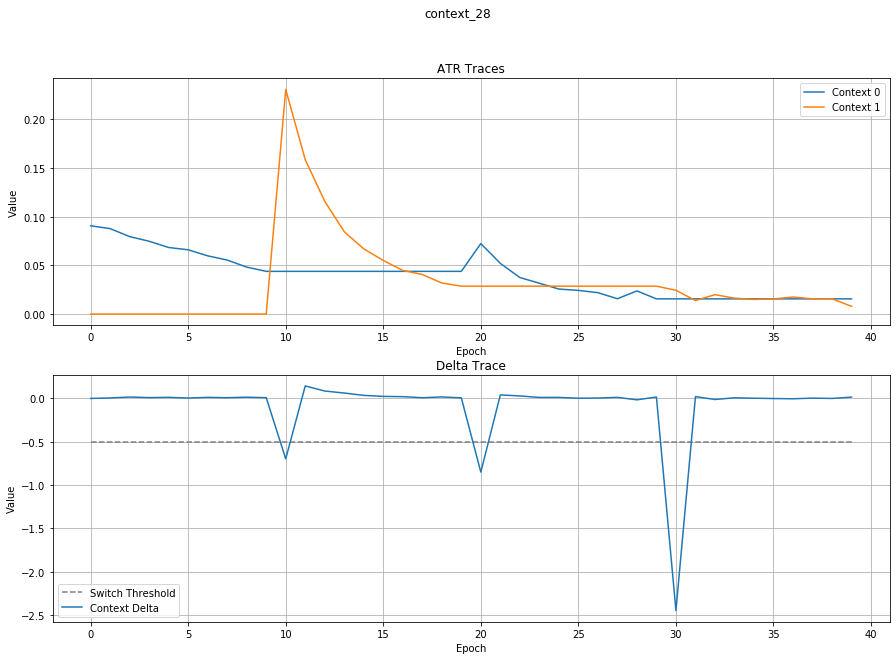

In [174]:
logger.plot(figsize=(15,10))

In [176]:
batch_size = 32
display_predictions = False
verbose = 0

%time evaluate(model, x_test, y_test_list, task_map, context_map, display_predictions, batch_size=batch_size, verbose=verbose)

CPU times: user 1.09 s, sys: 438 ms, total: 1.53 s
Wall time: 849 ms


[{'loss': 0.07605643570423126, 'accuracy': 0.9857000112533569},
 {'loss': 0.07920639961957932, 'accuracy': 0.9869999885559082}]

___

### 2. [Static nTL]: Divisibility - CNN

This second task continues to recognize even/odd/divisible by 3 numbers, but this time using a convolutional neural network (CNN). Again, this task is relatively simple but will be a powerful proof-of-concept since the n-task model could be compatible with CNNs.

#### Dataset

In [8]:
def create_divisibility_labels(labels):
    return (labels % 2 == 0).astype(int), (labels % 2 == 1).astype(int), (labels % 3 == 0).astype(int) # Even/Odd/divisible by 3

In [9]:
# Training Data
x_train = training_images.reshape(training_images.shape + (1,))[:5000]
y_train_list = create_divisibility_labels(training_labels[:5000])

# Testing Data
x_test = testing_images.reshape(testing_images.shape + (1,))[:1000]
y_test_list = create_divisibility_labels(testing_labels[:1000])

#### Seeding

In [10]:
set_seed(5)

#### Model Creation

In [11]:
# Optimizer
optimizer = tf.keras.optimizers.Adam(1e-3)

# Hyperparameters
hrr_size = 128
num_contexts = len(y_train_list)
switch_threshold = -0.005

# Model Architecture
inp = Input(x_train.shape[1:])
x = Conv2D(64, kernel_size=(8, 8), activation="relu")(inp)
x = Conv2D(128, (8, 8), activation="relu")(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.25)(x)
x = Flatten()(x)
x = Dense(hrr_size, activation="relu")(x)
x = Dropout(0.5)(x)
x = Context(num_contexts, AtrMovingAverage(switch_threshold))(x)
x = Dense(1, activation="sigmoid")(x)

# Create the model
model = NTaskModel(inputs=inp, outputs=x)

# Compile the model
model.compile(loss="bce", optimizer=optimizer, metrics=["accuracy"])

In [12]:
cycles     = 2
epochs     = 5
batch_size = 32

shuffle              = True  # Shuffle the active context dataset during training
task_shuffle         = True # Shuffle the contexts during training after first epoch
initial_task_shuffle = False # Shuffle the contexts before training

verbose = Verbosity.Progress | Verbosity.Contexts

logger = AtrLogger()
callbacks = [logger]

# model.fit(x_train, y_train_list[0], epochs=epochs, shuffle=shuffle)

# Train the model
%time task_map, context_map = train(model, x_train, y_train_list, cycles, epochs, task_shuffle, initial_task_shuffle, batch_size=batch_size, shuffle=shuffle, callbacks=callbacks, verbose=verbose)

Epoch 1/5
Epoch 2/5
Epoch 3/5
Epoch 4/5
Epoch 5/5
Epoch 6/10

[context] Switched context to 1
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
Epoch 11/15

[context] Switched context to 2
Epoch 12/15
Epoch 13/15
Epoch 14/15
Epoch 15/15
Epoch 16/20

[context] Switched context to 0
Epoch 17/20
Epoch 18/20
Epoch 19/20
Epoch 20/20
Epoch 21/25

[context] Switched context to 1
Epoch 22/25
Epoch 23/25
Epoch 24/25
Epoch 25/25
Epoch 26/30

[context] Switched context to 2
Epoch 27/30
Epoch 28/30
Epoch 29/30
Epoch 30/30
CPU times: user 2h 1min 51s, sys: 5min 25s, total: 2h 7min 16s
Wall time: 10min 54s


In [13]:
logger.plot(figsize=(5,5), savefile="graphs/mnist_static.pgf")

In [16]:
batch_size = 32
display_predictions = False
verbose = 0

%time evaluate(model, x_test, y_test_list, task_map, context_map, display_predictions, batch_size=batch_size, verbose=verbose)

CPU times: user 27.6 s, sys: 1.59 s, total: 29.2 s
Wall time: 2.41 s


[{'loss': 0.050898607820272446, 'accuracy': 0.9829999804496765},
 {'loss': 0.07184665650129318, 'accuracy': 0.9769999980926514},
 {'loss': 0.053294889628887177, 'accuracy': 0.9800000190734863}]

### 2. [Dynamic nTL]: Divisibility - CNN

This second task continues to recognize even/odd/divisible by 3 numbers, but this time using a convolutional neural network (CNN). Again, this task is relatively simple but will be a powerful proof-of-concept since the n-task model could be compatible with CNNs.

#### Dataset

In [17]:
def create_divisibility_labels(labels):
    return (labels % 2 == 0).astype(int), (labels % 2 == 1).astype(int), (labels % 3 == 0).astype(int) # Even/Odd/divisible by 3

In [18]:
# Training Data
x_train = training_images.reshape(training_images.shape + (1,))[:5000]
y_train_list = create_divisibility_labels(training_labels[:5000])

# Testing Data
x_test = testing_images.reshape(testing_images.shape + (1,))[:1000]
y_test_list = create_divisibility_labels(testing_labels[:1000])

#### Seeding

In [19]:
set_seed(5)

#### Model Creation

In [20]:
# Optimizer
optimizer = tf.keras.optimizers.Adam(1e-3)

# Hyperparameters
hrr_size = 128
num_contexts = len(y_train_list)
switch_threshold = -0.005
add_threshold = -0.004

# Model Architecture
inp = Input(x_train.shape[1:])
x = Conv2D(64, kernel_size=(8, 8), activation="relu")(inp)
x = Conv2D(128, (8, 8), activation="relu")(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.25)(x)
x = Flatten()(x)
x = Dense(hrr_size, activation="relu")(x)
x = Dropout(0.5)(x)
x = Context(1, AtrMovingAverage(switch_threshold, add_threshold, num_contexts))(x)
x = Dense(1, activation="sigmoid")(x)

# Create the model
model = NTaskModel(inputs=inp, outputs=x)

# Compile the model
model.compile(loss="bce", optimizer=optimizer, metrics=["accuracy"])

In [21]:
cycles     = 2
epochs     = 5
batch_size = 32

shuffle              = True  # Shuffle the active context dataset during training
task_shuffle         = True # Shuffle the contexts during training after first epoch
initial_task_shuffle = False # Shuffle the contexts before training

verbose = Verbosity.Progress | Verbosity.Contexts

logger = AtrLogger()
callbacks = [logger]

# model.fit(x_train, y_train_list[0], epochs=epochs, shuffle=shuffle)

# Train the model
%time task_map, context_map = train(model, x_train, y_train_list, cycles, epochs, task_shuffle, initial_task_shuffle, batch_size=batch_size, shuffle=shuffle, callbacks=callbacks, verbose=verbose)

Epoch 1/5
Epoch 2/5
Epoch 3/5
Epoch 4/5
Epoch 5/5
Epoch 6/10

[context_1] Adding context 1

[context_1] Switched context to 1
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
Epoch 11/15

[context_1] Adding context 2

[context_1] Switched context to 2
Epoch 12/15
Epoch 13/15
Epoch 14/15
Epoch 15/15
Epoch 16/20

[context_1] Switched context to 0
Epoch 17/20
Epoch 18/20
Epoch 19/20
Epoch 20/20
Epoch 21/25

[context_1] Switched context to 1
Epoch 22/25
Epoch 23/25
Epoch 24/25
Epoch 25/25
Epoch 26/30

[context_1] Switched context to 2
Epoch 27/30
Epoch 28/30
Epoch 29/30
Epoch 30/30
CPU times: user 2h 5min 6s, sys: 5min 36s, total: 2h 10min 42s
Wall time: 11min 47s


In [22]:
logger.plot(figsize=(5,5), savefile="graphs/mnist_dynamic.pgf")

In [23]:
batch_size = 32
display_predictions = False
verbose = 0

%time evaluate(model, x_test, y_test_list, task_map, context_map, display_predictions, batch_size=batch_size, verbose=verbose)

CPU times: user 27.8 s, sys: 609 ms, total: 28.4 s
Wall time: 2.45 s


[{'loss': 0.05088748782873154, 'accuracy': 0.9800000190734863},
 {'loss': 0.05445132404565811, 'accuracy': 0.9789999723434448},
 {'loss': 0.04033994674682617, 'accuracy': 0.9890000224113464}]